# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 10 декабря 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 10 декабря, -4 балла после 06:00 17 декабря, -6 баллов после 06:00 24 декабря -8 баллов  после 06:00 31 декабря

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 4] Фамилия Имя

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



Всего возможно $k^N$ различных разбиений $N$ точек на $k$ кластеров.  
Значит, за $k^N$ итераций будут рассмотрены все варианты разбиенияь. Алгоритм сойдется, так как на каждой итерации функционал $\sum_{n=1}^N \sum_{k=1}^K r_{n,k} ||x_n-\mu_n||^2$ уменьшается, и разбиение исходного множества, на котором достигается данный минимум, принадлежит нашему набору из $k^N$ различных разбиений.

***Ваше решение здесь***

Задача 2.  ММП для многомерного нормального распределения.

Функция правдоподобия в общем случае записывается как:
￼
￼$$ L(\theta) = p(X | \theta ) = \prod_{i=1}^N p(x_i | \theta)$$

Для многомерного нормального распределения плотность вероятности:
$$p(x_i| \theta) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}e^{-\frac{1}{2} (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)}$$

Выведите ММП оценку для вектора $\mu$
￼

Найдем производную логарифма функции плотности вероятности:
$$ \ln p(x_i|\theta) = -\frac{1}{2} \ln \left[ (2 \pi)^n \left|\Sigma \right| \right] -\frac{1}{2} \left( x_i - \mu \right)^T \Sigma^{-1} \left( x_i - \mu \right) $$  
$$\frac{\partial}{\partial \mu} \ln p(x_i|\theta) = -\frac{1}{2} \left( \Sigma^{-1} + \left(\Sigma^{-1}\right)^T \right) (x_i - \mu) = \Sigma^{-1} (\mu - x_i)$$  
Теперь просуммируем их, найдя таким образом логарифмическую функцию правдоподобия:
$$ \frac{\partial}{\partial \mu} \ln L(\theta) = \sum_{i=1}^N \Sigma^{-1} (\mu - x_i)$$  
Стало быть, условие экстремума
$$ N \cdot \mu - \sum_{i=1}^N x_i = 0 \Rightarrow \mu = \frac{1}{N} \sum_{i=1}^N x_i $$

***Ваше решение здесь***

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Для single справедлива формула
$$ d_{\min}(U \cup V, S) = \min[ d_{\min}(U, S), d_{\min}(V, S) ]  $$ 
Для complete:
$$ d_{\max}(U \cup V, S) = \max[ d_{\max}(U, S), d_{\max}(V, S) ]  $$ 
В первой формуле Ланса-Вильямса если 
$$ d_{\min}(U, S) > d_{\min}(V, S) $$ то, раскрывая модуль со знаком "+" получаем требуемое. Иначе-раскрываем со знаком "-" и также получаем то, что надо.
Вторую формулу можно рассмотреть аналогичным образом

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [40]:
from copy import deepcopy
import plotly.figure_factory as ff
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.cluster.hierarchy import dendrogram


In [4]:
def dist(X):
    ans = np.zeros(shape = (X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(i + 1, X.shape[0]):
            cur = set(X[i])
            tmp = deepcopy(cur)
            cur.symmetric_difference_update(set(X[j]))
            tmp.update(set(X[j]))
            if not len(tmp):
                ans[i][j] = 1
            else:
                ans[i][j] = len(cur) / len(tmp)
            ans[j][i] = ans[i][j]
    ans[np.arange(X.shape[0]),np.arange(X.shape[0])] = np.inf
    return ans
        

In [49]:
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self,n_clasters = 2, linkage = 'single', metric = 'euclidean' ):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clasters = n_clasters
        self.linkage = linkage
        
        self.metric = metric
        if metric == 'euclidean':
            self.dist = smt.pairwise.euclidean_distances
        if metric == 'manhattan':
            self.dist = smt.pairwise.manhattan_distances
        if metric == 'cosine':
            self.dist = smt.pairwise.cosine_similarity
        if metric == 'mine':
            self.dist = dist
        if linkage == 'single':
            self.a_i = 0.5
            self.a_j = 0.5
            self.c = -0.5
            self.b = 0
        if linkage == 'complete':
            self.a_i = 0.5
            self.a_j = 0.5
            self.c = 0.5
            self.b = 0
        if linkage == 'average':
            self.c = 0
            self.b = 0
        return
        
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.x_len = len(x)
        preds = pred_iris = [ 0 ] * self.x_len
        dist =  self.dist(x)
        dist[np.arange(self.x_len), np.arange(self.x_len)] = np.inf
        cur_clusts = np.arange(len(x))
        clusts_copy = cur_clusts
        temp = np.arange(len(x))
        self.Z = np.empty((self.x_len, 4))
        for i in range(1, self.x_len):
            merge = np.unravel_index(np.argmin(dist), dist.shape)
            a = np.where(cur_clusts == cur_clusts[merge[0]])[0]
            b = np.where(cur_clusts == cur_clusts[merge[1]])[0]
            self.Z[i] = [cur_clusts[merge[0]],cur_clusts[merge[1]], dist[merge], a.shape[0] + b.shape[0]]
            cur_clusts[b] =  self.x_len + i - 1
            cur_clusts[a] =  self.x_len + i - 1
            aggr = np.union1d(a,b)
            if self.linkage == 'average':
                self.a_i = a.shape[0] / (a.shape[0] + b.shape[0])
                self.a_j = len(b) / (a.shape[0] + b.shape[0])
            first = dist[a[0]]
            second = dist[b[0]]
            k = self.a_i * first + self.a_j*  second -\
            self.c * abs(first -  second)
            k[aggr] = np.inf
            dist[aggr] =  k
            k =  k.reshape(self.x_len,1)
            dist[:,aggr] =  k
            if (self.x_len - i == self.n_clasters):
                clusts_copy = deepcopy(cur_clusts)
        num = 0
        res = []
        met = dict()
        for i in range(self.x_len):
            if clusts_copy[i] not in met:
                met.update({clusts_copy[i] : num})
                num += 1
            res.append(met[clusts_copy[i]])
        preds = np.zeros(self.x_len, dtype=int)
        for i in range(preds.shape[0]):
            preds[i] = res[i]
        return preds
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        plt.figure(figsize=(20, 10))
        dendrogram(self.Z[1:])

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

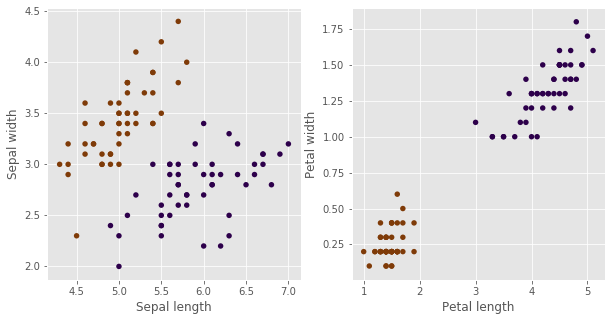

In [6]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()


Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [44]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.004163265228271484


In [50]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='manhattan', linkage = 'single')
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))


Our AGGL score 1.0. Our AGGL time 0.011593103408813477


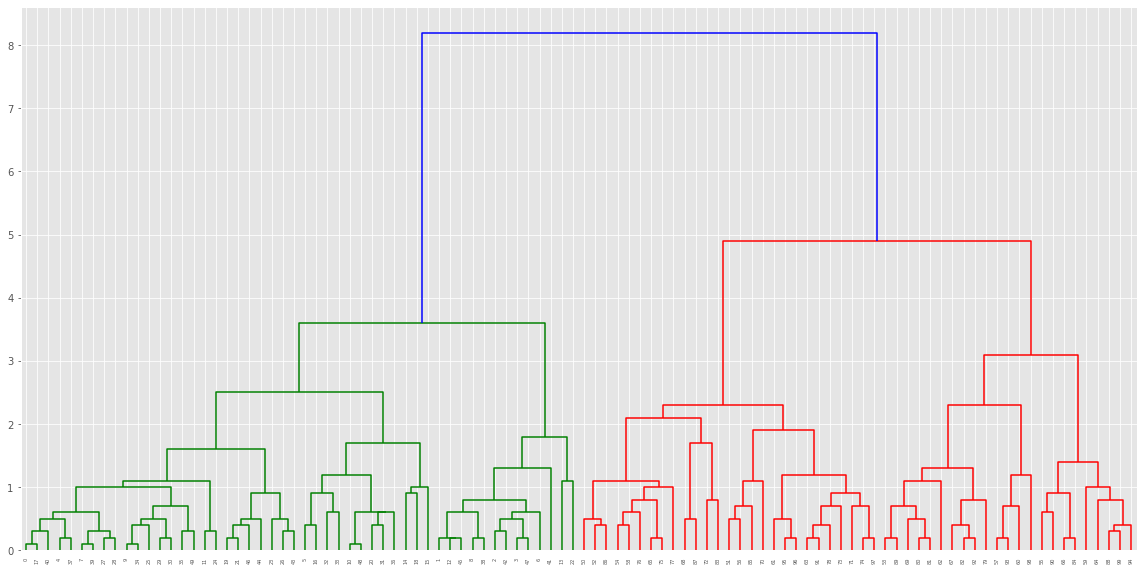

In [51]:
сustum_aggl.plot_dendrogram()


# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? 

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках.

In [17]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [18]:
import nltk
from nltk.corpus import stopwords
import pymorphy2

import pymorphy2
import requests
import pymorphy2
from googletrans import Translator
translator = Translator()

In [19]:
morph = pymorphy2.MorphAnalyzer()

def tokenize(title):
    words = title.strip()
    words = re.sub(r"[\W_0-9]", " ", words.lower())
    
    words = words.split()
    words = [word for word in words 
             if  word not in stopwords.words('english')]
    words = [morph.parse(i)[0].normal_form for i in words]
    allowed_forms = ['NOUN', 'INFN', 'ADJF']
    words = [morph.parse(i)[0].normal_form for i in words if morph.parse(i)[0].tag.POS in allowed_forms]
    return words

In [21]:
train_data = pd.read_csv('train_groups.csv')
from tqdm import tqdm
traingroups_titledata = {}
for i in tqdm(range(len(train_data))):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    words = tokenize(title)
    traingroups_titledata[doc_group].append((doc_id, words, target))

100%|██████████| 11690/11690 [01:01<00:00, 189.09it/s]


In [22]:
trains = deepcopy(traingroups_titledata)

In [23]:
test_data = pd.read_csv('test_groups.csv')
for i in tqdm(range(len(test_data))):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    words = tokenize(title)
    traingroups_titledata[doc_group].append((doc_id, words))

100%|██████████| 16627/16627 [01:30<00:00, 183.74it/s]


In [24]:
def trans(data_tok):
    n = 0
    row = list()
    col = list()
    dat = list()
    di = dict()
    for i in range(data_tok.shape[0]):
        for j in data_tok[i]:
            if (di.get(j, -1) == -1):
                di[j] = n
                n = n + 1
    for i in range(data_tok.shape[0]):
        cur = set()
        for j in range(len(data_tok[i])):
            if (data_tok[i][j] not in cur):
                dat.append(data_tok[i].count(data_tok[i][j]))
                row.append(i)
                col.append(di[data_tok[i][j]])
                cur.add(data_tok[i][j])
    ans = sp.sparse.csr_matrix((dat, (row, col)),shape = (data_tok.shape[0],n))
    ans =  smt.pairwise.cosine_similarity(ans)
    return np.array(ans, dtype = float)

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять, например, словами из тайтла.

Главное подобрать хорошую функцию расстояния между документами


Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

Давайте попробуем самый простой вариант(процент разных слов):

In [25]:
from sklearn.metrics import f1_score
def test():
    fin = 0.0
    for i in trains:
        titles = np.asarray([list(x[1]) for x in trains[i]])
        res = ([x[2] for x in trains[i]])
        res = np.array([not i for i in res])#Издержки нумерации кластеров
        k = f1_score(aggl.fit_predict(trans(titles)), res)
        fin += f1_score(aggl.fit_predict(trans(titles)), res)
    return fin / len(trains)

In [26]:
def test_for_best():
    fin = 0.0
    best = []
    for i in trains:
        titles = np.asarray([list(x[1]) for x in trains[i]])
        res = ([x[2] for x in trains[i]])
        res = np.array([not i for i in res])#Издержки нумерации кластеров
        k = f1_score(aggl.fit_predict(trans(titles)), res)
        if k > 0.8:
            print( i, ' ', k)
            best.append(trans(titles))
        fin += f1_score(aggl.fit_predict(trans(titles)), res)
    return best

In [27]:
import scipy as sp
aggl = Clustering( n_clasters = 2,metric = 'mine' ,linkage = 'single')
test()

0.3693020738308456

Неплохо, но, может, можно лучше

In [28]:
aggl = Clustering( n_clasters = 2,metric = 'manhattan' ,linkage = 'single')
test()

0.3842290422089557

In [29]:
aggl = Clustering( metric= 'cosine' ,linkage = 'single')
test()

0.35301964813932935

In [30]:
aggl = Clustering( metric= 'euclidean' ,linkage = 'single')
test()

0.34300933910033127

Посмотрим на лучшую метрику и отберем те группы, которые можно хорошо кластеризовать:

In [52]:
aggl = Clustering( n_clasters = 2,metric= 'manhattan' ,linkage = 'single')
tmp = test_for_best()

1   0.8502994011976047
44   0.8846153846153847
51   0.8901734104046243
56   0.9382716049382716
89   0.9161290322580644
105   0.8120300751879699
108   0.8027210884353742
113   0.8709677419354839


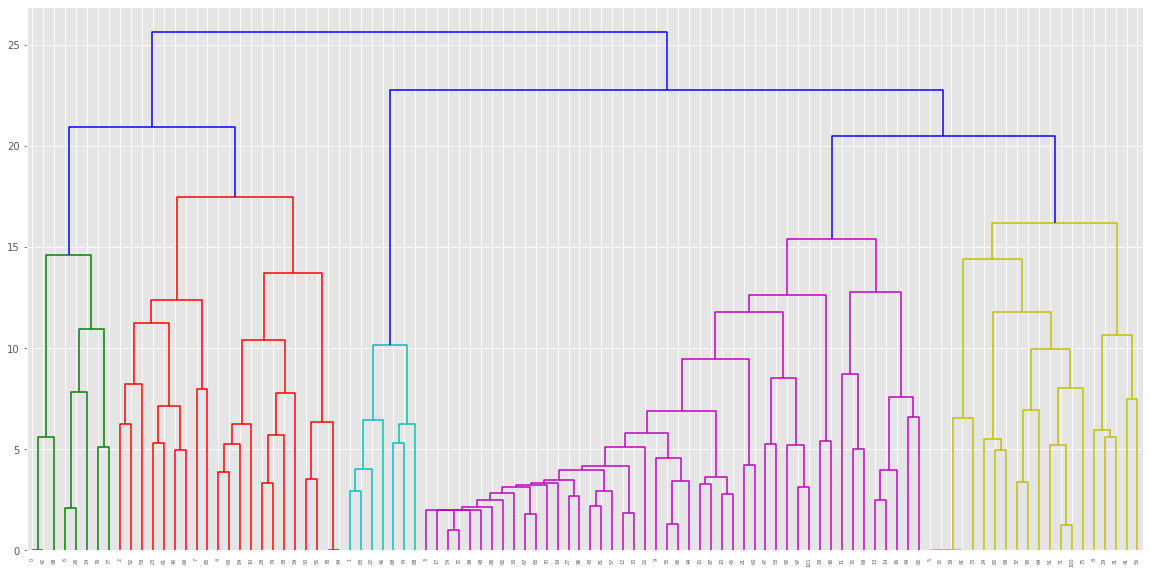

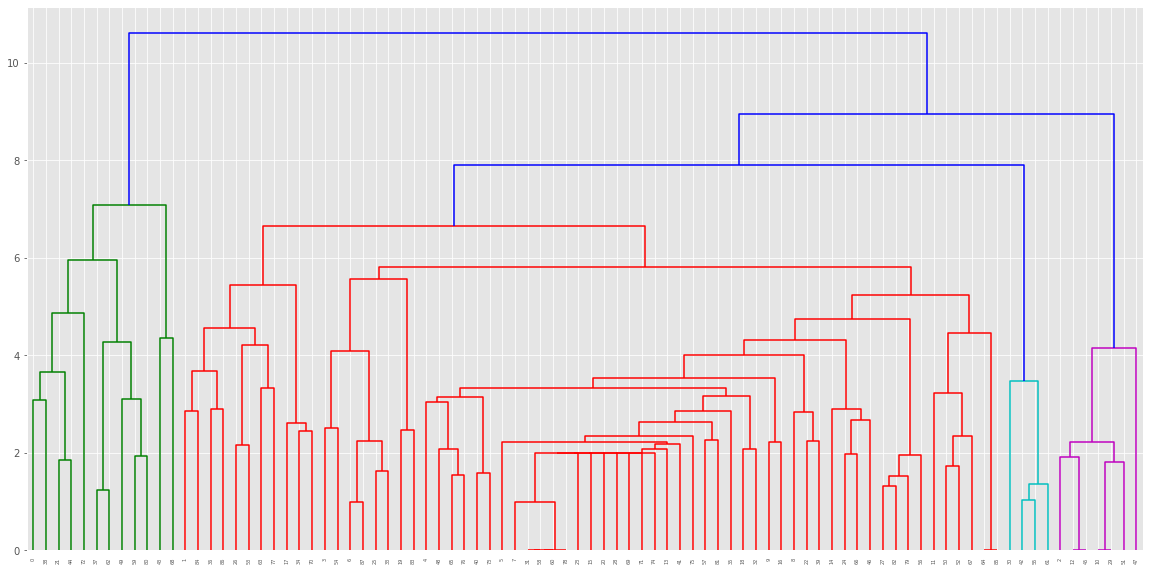

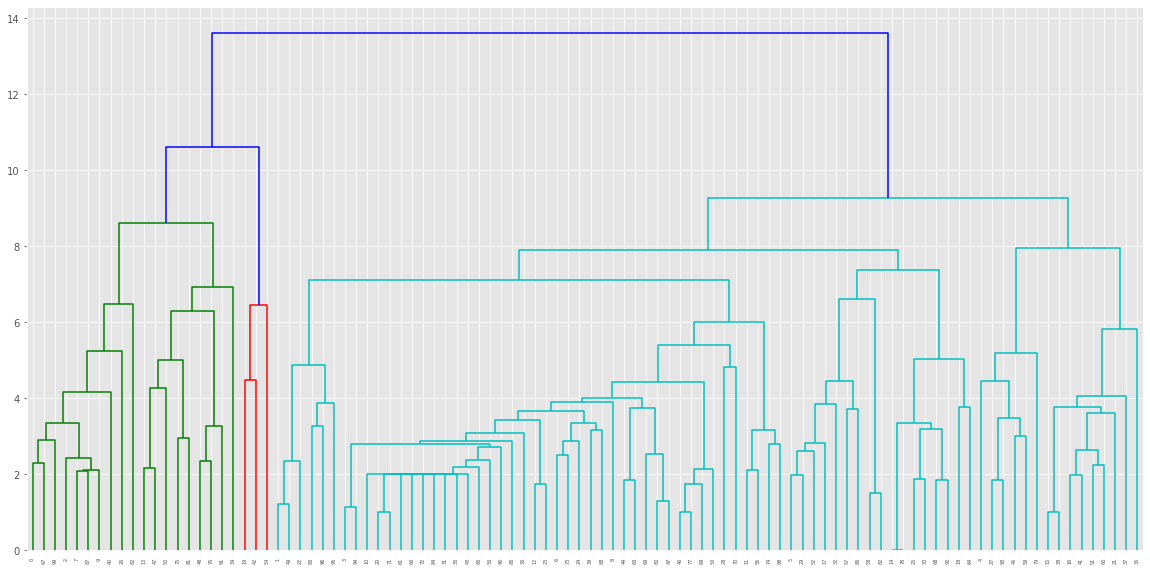

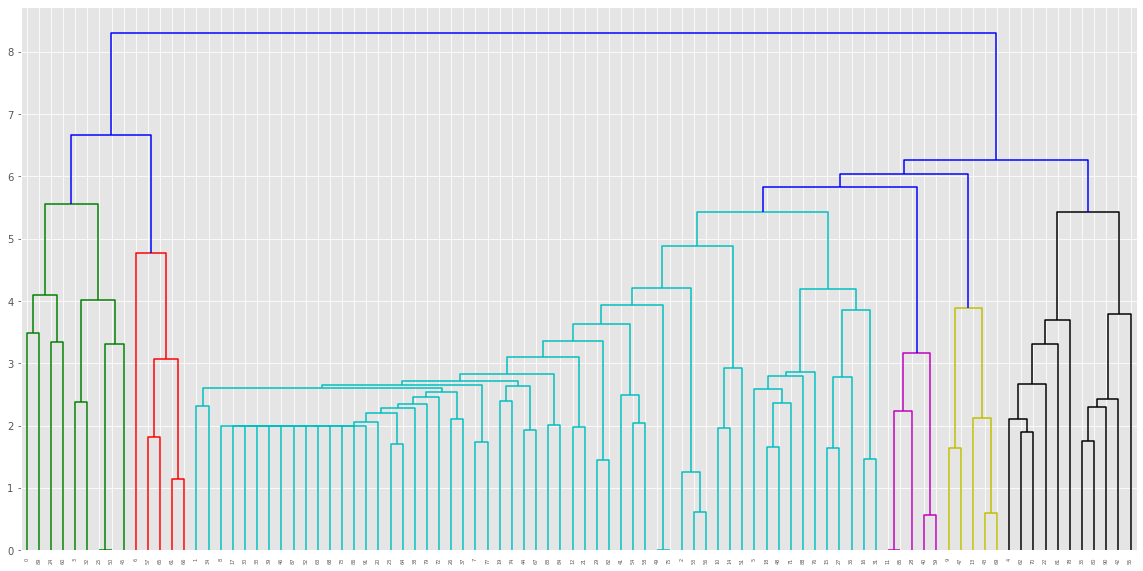

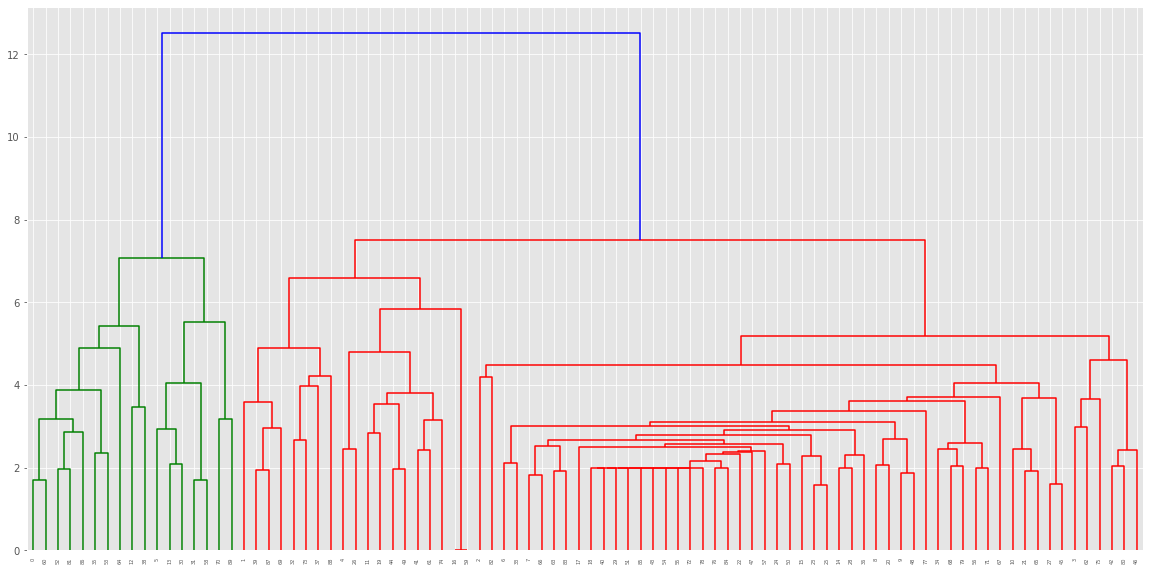

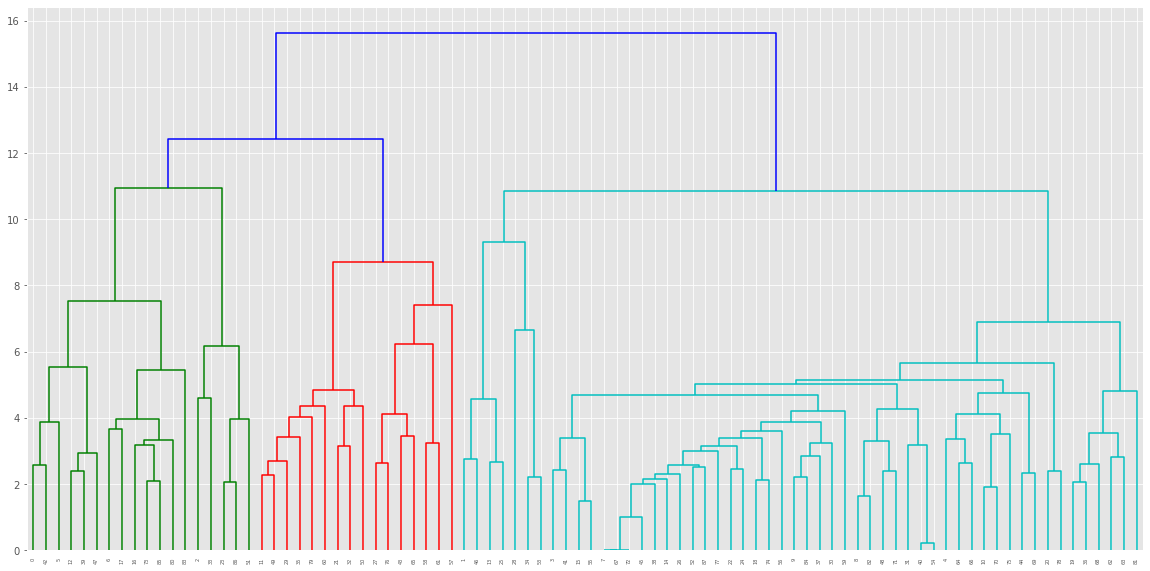

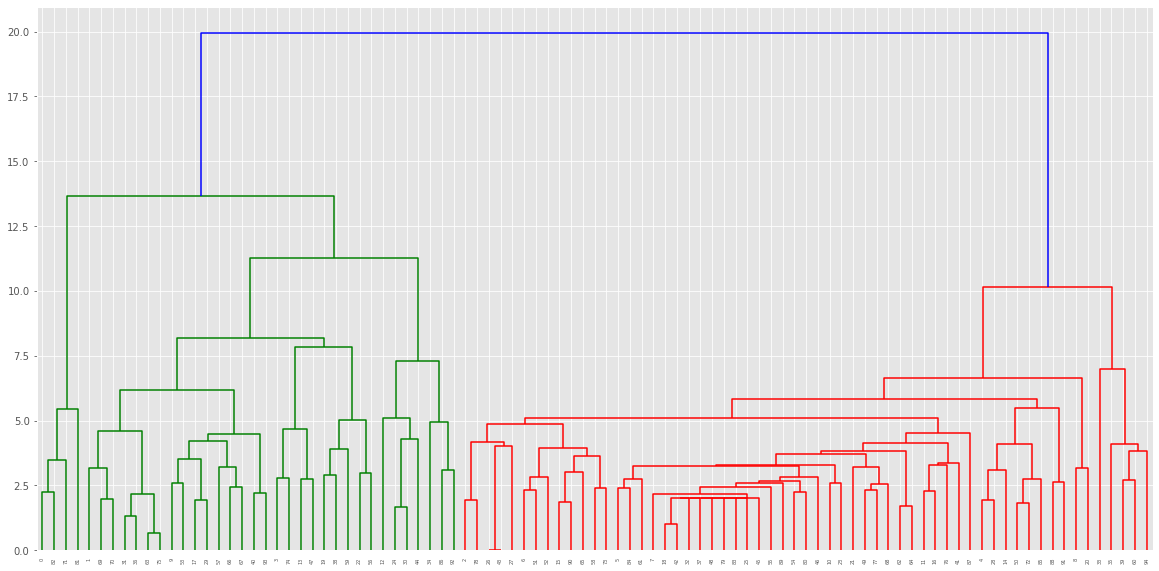

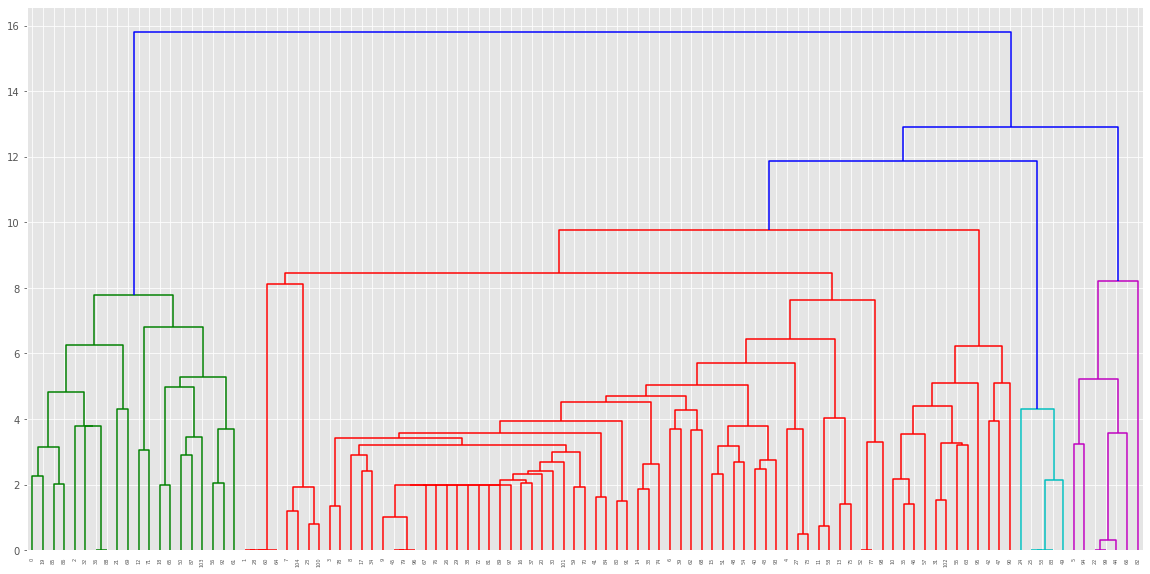

In [53]:
for i in range(len(tmp)):
    aggl.fit_predict(tmp[i])
    aggl.plot_dendrogram()


Во всех данных примерах есть кластер, который очень удален от остальный объектов. Можно надеяться, что он-это кластер не-выбросов(так как их меньше, чем выбросов, и выбросы с большей вероятностью будут постепенно объединяться, то есть, выбросы удалены друг от друга не настолько, насколько от не-выбросов)

Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

<b>Ответы на вопросы:</b>

1. В некоторых случаях удается понять по дентограмме, где находятся выбросы. Для этого нужно посмотреть, в каком случае расстояние между кластерами очень большое. Впрочем, это ненадежный способ, так как, если, например, выбросов больше, чем не-выбросов, то не-выбросы, скорее всего, попадут в один кластер с выбросами, и анализ усложнится.

2. Наши результаты показали, что в данном случае лучший выбор-манхэттенское расстояние, но чаще для анализа текстов используют косинусную меру.

3. Удалось получить f1-score равный 0,38. Это немного, но зато это работа выполненная только с помощью кластеризации. Дело в том, что в наших данных очень много выбросов, поэтому не-выбросы часто попадают в один кластер с выбросами, множества не разделяются и кластерный анализ становится затруднительным.

4. Кластерный анализ помогает понять, как локализованы данные в пространстве признаков, подобрать метрику для данной задачи. С его помощью можно проверить статистические гипотезы, выявить выбросы и сократить набор данных для дальнейшего обучения(с помощью отбора наиболее типичных представителей кластеров). 

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Интересная домашняя работа, как и остальные

Хороший курс, полезный. Дает основополагающие знания для дальнейшей работы в data science